In [249]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

##  Partie 1 : Echelle unique et inhibition

####  Calcul du Gradient avec un Noyau Gaussien

In [250]:
import numpy as np
from scipy.ndimage import convolve

def scale_dependent_gradient(image, sigma):
    # Fonction pour calculer le gradient à dépendance d'échelle
    # Création des noyaux gaussiens dérivés
    Gx, Gy = gaussian_derivative_kernels(sigma)
    
    # Convolution de l'image avec les noyaux dérivés
    F_sigma_x = convolve(image, Gx, mode='nearest')
    F_sigma_y = convolve(image, Gy, mode='nearest')
    
    # Calcul de la magnitude du gradient
    M_sigma = np.sqrt(F_sigma_x**2 + F_sigma_y**2)
    
    # Normalisation
    M_sigma /= np.max(M_sigma)
    
    return M_sigma

def gaussian_derivative_kernels(sigma):
    # Fonction pour créer les noyaux gaussiens dérivés
    # Taille du noyau (un multiple de sigma)
    sz = int(np.ceil(sigma * 3) * 2 + 1)
    
    # Création du noyau gaussien
    X, Y = np.meshgrid(np.arange(-sz/2, sz/2 + 1), np.arange(-sz/2, sz/2 + 1))
    G = np.exp(-(X**2 + Y**2) / (2 * sigma**2)) / (2 * np.pi * sigma**2)
    
    # Dérivées du noyau gaussien
    Gx = -X * G / sigma**2
    Gy = -Y * G / sigma**2
    
    return Gx, Gy


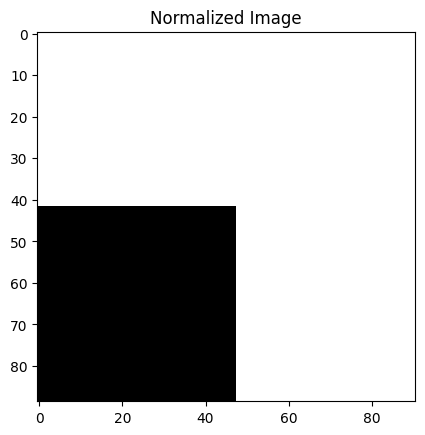

In [251]:
import cv2
import matplotlib.pyplot as plt

# Read the image
image = cv2.imread('carre_blanc.jpg', cv2.IMREAD_UNCHANGED)

if image is None:
    print("Error: Unable to read the image.")
else:
    # Convert to float
    image = image.astype(float)

    # Normalize the image values to be between 0 and 1
    image_normalized = (image - image.min()) / (image.max() - image.min())

    # Display the normalized image
    plt.imshow(image_normalized, cmap='gray')
    plt.title('Normalized Image')
    plt.show()


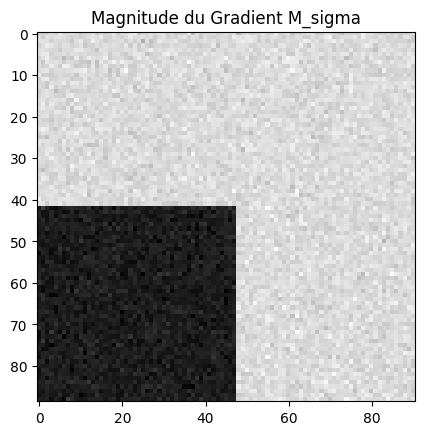

In [252]:
## adding noise to the image 

noise = np.random.normal(0, 1, image_normalized.shape)
image_noisy = (1-0.05)*image_normalized + 0.05*noise

plt.imshow(image_noisy, cmap='gray')
plt.title('Magnitude du Gradient M_sigma')
plt.show()

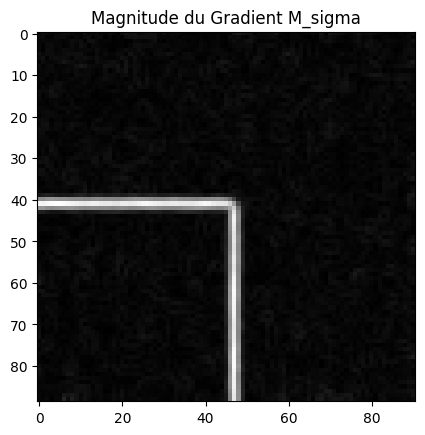

In [253]:
# Partie 1 : Echelle unique et inhibition
# Calcul du Gradient avec un Noyau Gaussien
# paramètre
sigma = 1

M_sigma = scale_dependent_gradient(image_noisy, sigma)

# Afficher le gradient
plt.imshow(M_sigma, cmap='gray')
plt.title('Magnitude du Gradient M_sigma')
plt.show()


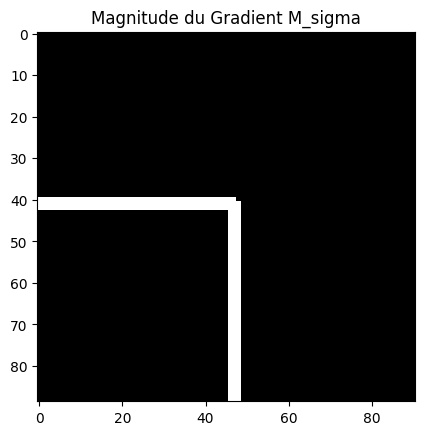

In [254]:
## select only vamues of M_sigma > 0.2 and plot the image in gray scale

M_sigma_seuil = np.zeros_like(M_sigma)

for i in range(M_sigma.shape[0]):
    for j in range(M_sigma.shape[1]):
        if M_sigma[i, j] > 0.2:
            M_sigma_seuil[i,j] = 1


plt.imshow(M_sigma_seuil, cmap='gray')
plt.title('Magnitude du Gradient M_sigma')
plt.show()

#### Inhibition des Contours Environnants

In [255]:


def difference_of_gaussians(sigma):
    # Taille du noyau (un multiple de sigma)
    sz = int(np.ceil(sigma * 3) * 2 + 1)
    
    # Création de la grille de coordonnées
    X, Y = np.meshgrid(np.arange(-sz/2, sz/2 + 1), np.arange(-sz/2, sz/2 + 1))
    
    # Calcul des deux gaussiennes
    G1 = np.exp(-(X**2 + Y**2) / (2 * (sigma * 4)**2))
    G2 = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    
    # Difference of Gaussians
    dog = np.maximum(G1 / (2 * np.pi * (sigma * 4)**2) - G2 / (2 * np.pi * sigma**2), 0)
    
    return dog

def normalization_term(sigma):
    # Calcul du DoG
    dog = difference_of_gaussians(sigma)
    
    # Calcul du terme de normalisation
    w_sigma = dog / np.sum(dog**2)
    
    return w_sigma

def suppression_term(M_sigma, sigma):
    # Calcul du DoG
    w_sigma = normalization_term(sigma)
    
    # Convolution du DoG avec la magnitude du gradient
    t_sigma = convolve(M_sigma, w_sigma, mode='nearest')
    
    return t_sigma

def contour_inhibition(M_sigma, sigma, alpha):
    # Calcul du terme de suppression
    t_sigma = suppression_term(M_sigma, sigma)
    
    # Supprimer les valeurs négatives
    t_sigma = np.maximum(t_sigma, 0)
    
    # Inhibition de contour
    c_sigma = M_sigma - alpha * t_sigma
    
    # Supprimer les valeurs négatives
    c_sigma = np.maximum(c_sigma, 0)
    
    return c_sigma


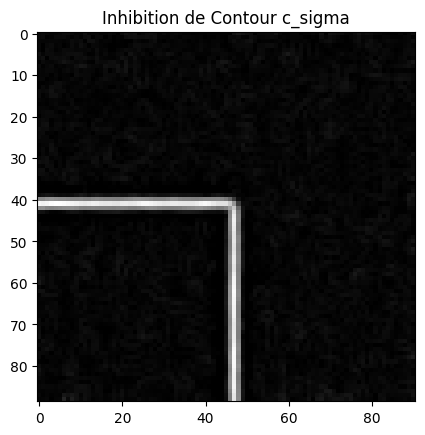

In [256]:
# paramètre
alpha = 0.001



c_sigma = contour_inhibition(M_sigma  , sigma , alpha)


# Afficher l'inhibition
plt.imshow(c_sigma, cmap='gray')
plt.title('Inhibition de Contour c_sigma')
plt.show()

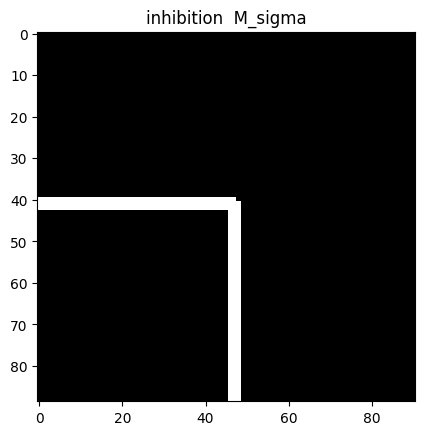

In [257]:
C_sigma_seuil = np.zeros_like(c_sigma)

for i in range(c_sigma.shape[0]):
    for j in range(c_sigma.shape[1]):
        if c_sigma[i, j] > 0.2:
            C_sigma_seuil[i,j] = 1


plt.imshow(C_sigma_seuil, cmap='gray')
plt.title('inhibition  M_sigma')
plt.show()

#### Seuillage par hystérésie et suppression des non-maxima

In [258]:
from skimage import img_as_float

def find_neighbors(angle, i, j):
    # Détermination de la direction du gradient
    if (angle > -np.pi/8 and angle <= np.pi/8) or (angle > 7*np.pi/8 or angle <= -7*np.pi/8):
        neighb1 = (i, j+1); neighb2 = (i, j-1)

    elif (angle > np.pi/8 and angle <= 3*np.pi/8) or (angle > -7*np.pi/8 and angle <= -5*np.pi/8):
        neighb1 = (i-1, j+1); neighb2 = (i+1, j-1)
    elif (angle > 3*np.pi/8 and angle <= 5*np.pi/8) or (angle > -5*np.pi/8 and angle <= -3*np.pi/8):
        neighb1 = (i-1, j); neighb2 = (i+1, j)
    elif (angle > 5*np.pi/8 and angle <= 7*np.pi/8) or (angle > -3*np.pi/8 and angle <= -np.pi/8):
        neighb1 = (i-1, j-1); neighb2 = (i+1, j+1)
    
    return neighb1, neighb2

def supp_non_max(c_sigma):
    # Calcul du gradient
    Fx, Fy = np.gradient(img_as_float(c_sigma))
    angle =  np.pi/2 + np.arctan2(Fy, Fx)
    minangle = 3.14
    maxangle = 0

    # Suppression des non-maximas
    non_max_suppressed = np.zeros_like(c_sigma)
    for i in range(0, angle.shape[0]-1):
        for j in range(0, angle.shape[1]-1):
            
            if  (angle[i,j] >= 3.14) :
                angle[i,j] = angle[i,j] - 3.14

            if angle[i,j]   > maxangle :
                maxangle = angle[i,j]

                
            if angle[i,j] <= minangle :
                minangle = angle[i,j]


            # Trouver les voisins dans la direction du gradient
            neighb1, neighb2 = find_neighbors(angle[i, j], i, j)
            
            # Suppression des non-maxima
            if c_sigma[i, j] >= c_sigma[neighb1] and c_sigma[i, j] >= c_sigma[neighb2]:
                non_max_suppressed[i, j] = c_sigma[i, j]
                
    
    return non_max_suppressed , minangle , angle , maxangle 

def seuil_hyst(c_sigma, seuil_bas, seuil_haut):
    # Suppression des non-maximas
    non_max_suppressed , mina  , angle , maxangle  = supp_non_max(c_sigma)
    
    b_sigma = np.zeros_like(c_sigma)
    b_sigma[non_max_suppressed >= seuil_haut] = 1
    
    # Propagation des pixels forts aux faibles
    for i in range(1, c_sigma.shape[0]-1):
        for j in range(1, c_sigma.shape[1]-1):
            if non_max_suppressed[i, j] >= seuil_bas:
                if np.any(b_sigma[i-1:i+2, j-1:j+2] == 1):
                    b_sigma[i, j] = 1
    print("-----------")
    print(mina)
    print('----------')


    print("-----------")
    print(maxangle)
    print('----------')

    
    return b_sigma , angle

-----------
-1.5707563924270733
----------
-----------
3.1399887568012437
----------


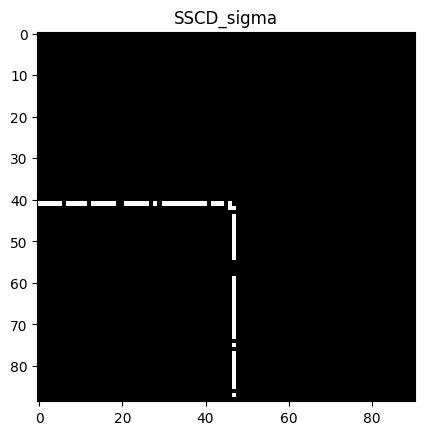

In [259]:
# Seuils à ajuster en fonction de l'image qu'on met en entrée
seuil_bas = 0.001
seuil_haut = 0.2


b_sigma , ang = seuil_hyst(c_sigma, seuil_bas, seuil_haut)

# Afficher le résultat final
plt.imshow(b_sigma, cmap='gray')
plt.title('SSCD_sigma')
plt.show()

In [260]:
## search index for all values greater than 3.14
index_greater_than_3_14 = np.where(ang > 3.14)

index_greater_than_3_14


(array([ 0,  5, 13, 17, 18, 20, 33, 35, 42, 50, 53, 54, 55, 60, 69, 78, 80,
        84, 87, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88,
        88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88], dtype=int64),
 array([90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
        90, 90,  0, 14, 17, 22, 23, 32, 33, 45, 46, 51, 52, 53, 54, 57, 58,
        62, 63, 66, 70, 74, 79, 82, 86, 87, 89, 90], dtype=int64))

In [261]:
ang[40]

array([ 1.56569158,  1.60511119,  1.62109965,  1.56677988,  1.54360582,
        1.5597541 ,  1.55750129,  1.53993209,  1.55171414,  1.57451887,
        1.55648873,  1.5473105 ,  1.59282466,  1.60935873,  1.57150298,
        1.54367961,  1.55871383,  1.56694929,  1.55865921,  1.57901308,
        1.60033267,  1.60687681,  1.61624359,  1.5965305 ,  1.55990518,
        1.55038366,  1.54491833,  1.53420072,  1.54911915,  1.57072382,
        1.5938705 ,  1.6273593 ,  1.60117513,  1.52578348,  1.5183255 ,
        1.56166909,  1.56005808,  1.54797566,  1.57898117,  1.60016336,
        1.58355259,  1.57432617,  1.57971213,  1.56099071,  1.50937528,
        1.4308017 ,  1.23708502,  1.00307344,  0.80188118,  0.73007779,
        2.1758959 ,  2.20004925, -1.48666405, -1.24692894,  0.79000935,
       -0.83504843,  1.96809804,  0.97534487, -0.41521928, -0.01784519,
        2.89751931,  0.1789081 ,  1.27190102,  0.14100368,  0.44923776,
       -1.14512063, -0.15663634, -1.28940528,  0.4623346 ,  0.84

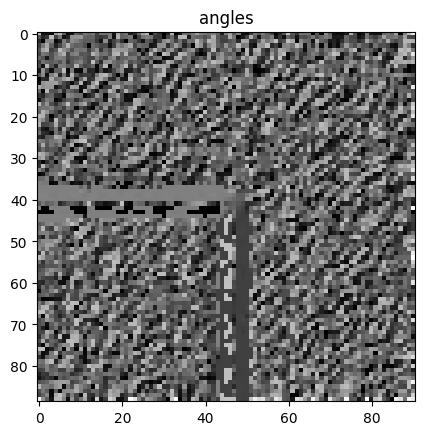

In [262]:
# Afficher le résultat final
plt.imshow(ang, cmap='gray')
plt.title('angles')
plt.show()

## Partie 2 : Echelle multiple et Canny

In [263]:
def SingleScaleContourDetector(image , sigma , seuil_bas , seuil_haut ,alpha):
    # Calcul du Gradient avec un Noyau Gaussien
    M_sigma = scale_dependent_gradient(image, sigma)
    
    
    c_sigma = contour_inhibition(M_sigma, sigma, alpha)
    
    # Seuillage hystérésique et suppression des non-maxima
    
    SSCD = seuil_hyst(c_sigma, seuil_bas, seuil_haut)
    
    return SSCD

-----------
-1.5707563924270733
----------
-----------
3.1399887568012437
----------


TypeError: Invalid shape (2, 89, 91) for image data

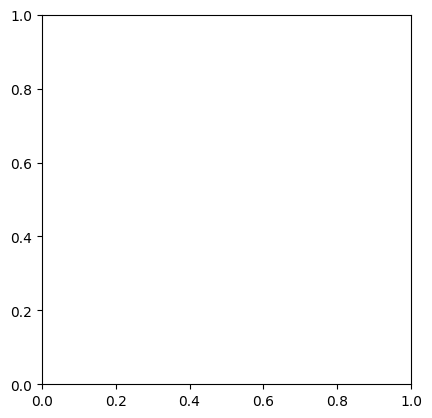

In [264]:
# Canny edge detection for sigma = 1
b1 = SingleScaleContourDetector(image_noisy , 1 , seuil_bas,seuil_haut , alpha)

# Afficher le résultat final
plt.imshow(b1, cmap='gray')
plt.title('SSCD_sigma')
plt.show()

In [ ]:
def dilat_morph(image):
    # Opérateur DTO
    rows, cols = np.where(image > 0)
    beta = np.zeros((image.shape[0] * 2, image.shape[1] * 2))
    beta[rows * 2, cols * 2] = 1
    
    # Dilatation morphologique
    se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))  # Use MORPH_ELLIPSE for a disk-shaped structuring element
    dto = cv2.dilate(beta.astype(np.uint8), se)
    
    return dto

In [ ]:
def doubling_and_ticking_operator(binary_map):
    # Double the coordinates of nonzero pixels
    doubled_coordinates = np.zeros_like(binary_map)
    doubled_coordinates[binary_map > 0] = 1

    # Create an array to represent the disk of radius 3 pixels
    radius = 3
    y, x = np.ogrid[-radius:radius+1, -radius:radius+1]
    disk = x**2 + y**2 <= radius**2

    # Substitute each nonzero pixel with the disk of radius 3 pixels
    result = np.zeros_like(binary_map)
    for y, row in enumerate(doubled_coordinates):
        for x, value in enumerate(row):
            if value > 0:
                result[y - radius:y + radius + 1, x - radius:x + radius + 1] = disk

    return result

In [ ]:
def decim_im(image, N):
    sigma = 2**N
    sz = int(np.ceil(sigma * 3) * 2 + 1)
    X, Y = np.meshgrid(np.arange(-sz/2, sz/2 + 1), np.arange(-sz/2, sz/2 + 1))
    G = np.exp(-(X**2 + Y**2) / (2 * sigma**2)) / (2 * np.pi * sigma**2)
    im_convolu = convolve(image.astype(np.float32), G.astype(np.float32), mode='constant', cval=0.0)
    im_decimee = cv2.resize(im_convolu, None, fx=1/2**(N-1), fy=1/2**(N-1), interpolation=cv2.INTER_CUBIC).astype(np.float32)
    return im_decimee

-----------
-1.5695721882750924
----------
-----------
3.139163145352365
----------
-----------
-1.569499205267586
----------
-----------
3.1398033957981237
----------


TypeError: Invalid shape (2, 89, 91) for image data

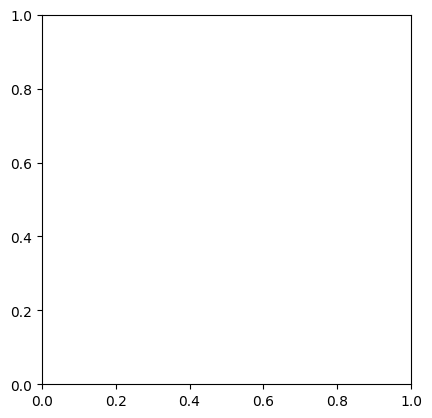

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Détection des Contours à l'Échelle Originale avec Canny sigma = 1 et 2
# Seuils à ajuster en fonction de l'image qu'on met en entrée
seuil_bas = 0.0000000000001
seuil_haut = 0.2
alpha = 0.001

# Canny edge detection for sigma = 1
b1 = SingleScaleContourDetector(image_noisy , 1 , seuil_bas,seuil_haut , alpha)
# Canny edge detection for sigma = 2
b2 = SingleScaleContourDetector(image_noisy , 2 , seuil_bas,seuil_haut , alpha)

# Afficher les résultats
plt.imshow(b1, cmap='gray')
plt.title('b1')
plt.show()

plt.imshow(b2, cmap='gray')
plt.title('b2')
plt.show()

K = 2  # Decimation factor
b2_decimated = decim_im(b2 , K)


dto2 =dilat_morph(b2_decimated)

# Affichage du DTO
plt.imshow(dto2, cmap='gray')
plt.title('DTO')
plt.show()

# Ensure b1 and dto have the same dimensions
b1 = cv2.resize(b1, (dto2.shape[1], dto2.shape[0]))

# Convert b1 to the same data type as dto
b1 = b1.astype(np.uint8)

# Superposition visuelle de b1 et DTO
superposition_visuelle = cv2.addWeighted(b1, 0.5, dto2, 0.5, 0)

plt.imshow(superposition_visuelle, cmap='gray')
plt.title('Superposition Visuelle de b1 et DTO')
plt.show()

# Opération logique AND entre b1 et DTO
b1_and_dto = cv2.bitwise_and(b1, dto2)

plt.imshow(b1_and_dto, cmap='gray')
plt.title('b1 AND DTO')
plt.show()


##  Partie 3 : Echelle multiple et inhibition

In [ ]:
# Paramètres
N = 5  # Nombre d'échelles
alpha =0.01
# Tableau de matrices et calcul des images à plusieurs échelles
images_decimees = [None] * N
images_decimees[0] = image_noisy

for n in range(2, N + 1):
    images_decimees[n-1] = decim_im(image_noisy,  n)

# Détection de contours à chaque échelle
contours_binaires = [None] * N

for n in range(N):
    contours_binaires[n] = SingleScaleContourDetector(images_decimees[n] , 1 , seuil_bas , seuil_haut , alpha)

# Combine les contours à différentes échelles : de la plus grossière et en descendant progressivement
resultat_final = contours_binaires[N-1]

for n in range(N-2, -1, -1):
    # Dilatation du résultat actuel
    dto = dilat_morph(contours_binaires[n+1])

    # Ensure b1 and dto have the same dimensions
    contours_binaires[n] = cv2.resize( contours_binaires[n], (dto.shape[1], dto.shape[0]))
    
    # Convert b1 to the same data type as dto
    contours_binaires[n] = contours_binaires[n].astype(np.uint8)

   

    # Combinaison avec la carte de contours à l'échelle suivante
    resultat_final = cv2.bitwise_and(contours_binaires[n], dto)

    plt.imshow(resultat_final, cmap='gray')
    plt.title('Résultat de la détection de contours multiscale avec inhibition du contour, étape : ' + str(n+1))
    plt.show()

plt.imshow(resultat_final, cmap='gray')
plt.title('Résultat de la détection de contours multiscale avec inhibition du contour')
plt.show()

-----------
-1.5672232227779443
----------
-----------
3.1397218367982536
----------
-----------
-1.5293428
----------
-----------
3.1383915
----------
-----------
-1.1860412
----------
-----------
2.8301725
----------
-----------
0.0
----------
-----------
1.572389
----------
-----------
0.0
----------
-----------
1.572389
----------


TypeError: '>' not supported between instances of 'tuple' and 'int'